<a href="https://colab.research.google.com/github/xcoga/SC3000-assignment-1-cartpole/blob/main/SC3000Assignment1(Main)(Git).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from typing import List, Tuple, Dict, Any, Union, Optional

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Checking the environment's properties
Properties: <br>
&emsp; `action_space`: 0 or 1. There are two possible actions: 0 for pushing to the left and 1 for pushing to the right. <br>
&emsp; `observation_space`: array(2, 4). The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity. <br>
<br>
Method: `env.step(action)` <br>
&emsp;args: <br>
&emsp;&emsp;`action`: 0 or 1 <br>
&emsp;return: <br>
&emsp;&emsp;`observation`: array(4,) (float) <br>
&emsp;&emsp;`reward`: float <br>
&emsp;&emsp;`done`: bool <br>


For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
env = gym.make("CartPole-v1")
print("What is the environment's action space: ", env.action_space, "(expecting Discrete(2))")
print("What is the environment's observation looks like: ",env.observation_space, "(expecting Box(4,))")

env.reset()

observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

env.reset()

What is the environment's action space:  Discrete(2) (expecting Discrete(2))
What is the environment's observation looks like:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32) (expecting Box(4,))
New observations after choosing action 0: [ 0.00195412 -0.16314922  0.00946105  0.26450822]
Reward for this step: 1.0
Is this round done? False


array([0.03659724, 0.01657145, 0.01815124, 0.02861934], dtype=float32)

## Task 1: Development of an RL agent

## 1. Q-learning agent

### 1.1 Function for creating a Q-table and discrete real state to discrete space

In [ ]:
def create_bins(numBins):
  """ Discretize the real state space into discrete state space, by creating bins for each dimension.

  Args:
      numBins (int): number of bins to discretize the state space

  Returns:
      bins: (array(4, numBins)): new discrete state space
  """
	# Get the size of each bucket
  #For buckets for velocity and angular velocity to be changed.
  #list arrangement is: cart position, velocity and pole angle, angular velocity.
  bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
  ]
  return bins

def create_q_table(obsSpaceSize, actionSpaceSize, numBins):
  """Create a q table for the given environment and discretization.

  Args:
      obsSpaceSize (int): observation space size (here for cartpole it is 4)
      actionSpaceSize (int): action space size (here for cartpole it is 2)
      numBins (int): number of bins to discretize the state space

  Returns:
      q_table: (array(numBins^4, 2)): q table
  """
  # Create a q table with the given number of bins
  # q_table = np.random.uniform(low=-1,high=1,size=([numBins] * obsSpaceSize + [actionSpaceSize]))
  q_table = np.zeros([numBins] * obsSpaceSize + [actionSpaceSize])
  return q_table

### 1.2 Reinforcement Learning Agent with Q-Table algorithm

In [ ]:
class QAgent(object):
  def __init__(self, env, bins: List, q_table: List, training_args):
    self.env = env
    self.bins = bins
    self.q_table = q_table
    self.training_args = training_args

  def convert_to_discrete(self, state):
    """ Convert real state space returned by environment to discrete state space.

    Args:
        state (array(4, )): real state space

    Returns:
        discrete_state (array(4, )): discrete state space
    """
    discrete_state = []
    for i in range(self.env.observation_space.shape[0]):
      discrete_state.append(np.digitize(state[i], self.bins[i]) - 1)
    return tuple(discrete_state)

  def choose_action(self, state):
    """Choose the next action based on current environment state and epsilon.

    Args:
        state (array(4, )): current environment state

    Returns:
        int: next action
    """
    state = self.convert_to_discrete(state)
    if np.random.random() > self.training_args.epsilon:
      # print("Choose action based on q table")
      action = np.argmax(self.q_table[state])
    else:
      # print("Choose action randomly")
      action = random.randint(0, self.env.action_space.n-1)
    return action

  def choose_action_test(self, state):
    "choose action without randomness during test"
    state = self.convert_to_discrete(state)
    # print("Choose action based on q table")
    action = np.argmax(self.q_table[state])
    return action

  def _update_q_table(self, state, action, reward, newState):
    state = self.convert_to_discrete(state)
    newState = self.convert_to_discrete(newState)
    oldQ = self.q_table[state+(action,)]
    maxFutureQ = np.max(self.q_table[newState])
    newQ = oldQ + self.training_args.learning_rate * (reward + self.training_args.discount * maxFutureQ - oldQ)
    self.q_table[state + (action,)] = newQ

  def train(self):
    cumulative_reward = []
    for episode in range(self.training_args.episodes):
      state = self.env.reset()
      complete = False
      steps = 0
      reward_for_this_episode = 0
      while not complete:
        steps += 1
        action = self.choose_action(state)
        newState, reward, done, _ = self.env.step(action)
        reward_for_this_episode += reward

        #if current state hits terminating conditions, or steps reaches 500, update complete to True
        # The terminating conditions are from the OpenAI Gym CartPole-v0 environment: https://www.gymlibrary.dev/environments/classic_control/cart_pole/
        if (newState[0]>2.4 or -2.4 > newState[0] or newState[2]>.2095 or -0.2095 > newState[2] or steps==self.training_args.maximum_steps_per_episode):
          complete = True
          reward += self.training_args.outofbounds_reward
        # Update q table
        self._update_q_table(state, action, reward, newState)

        state = newState

      cumulative_reward.append(reward_for_this_episode)
      self.training_args.epsilon *= self.training_args.epsilon_decay_value
      self.training_args.epsilon = max(0.01, self.training_args.epsilon)
      print("Episode: ", episode, "Reward: ", reward_for_this_episode)
    return cumulative_reward

  def test(self, num_episodes=100):
    cumulative_reward = []
    epsilon = self.training_args.epsilon
    for episode in range(num_episodes):
      state = self.env.reset()
      complete = False
      steps = 0
      reward_for_this_episode = 0
      while not complete:
        steps += 1
        action = self.choose_action_test(state)
        newState, reward, done, _ = self.env.step(action)
        reward_for_this_episode += reward
        if (newState[0]>2.4 or -2.4 > newState[0] or newState[2]>.2095 or -0.2095 > newState[2] or steps==self.training_args.maximum_steps_per_episode):
          complete = True
        state = newState

      cumulative_reward.append(reward_for_this_episode)
    return cumulative_reward

### 1.3 Define constants and variables to be used for q learning

In [ ]:
# Traing arguments
LEARNING_RATE = 0.3     #LEARNING RATE
DISCOUNT = 0.995        #DISCOUNT
EPISODES = 10000        # How many episodes we want to train for
SHOW_EVERY = 2000       # How often the current solution is rendered
UPDATE_EVERY = 100      # How often the current progress is recorded
EPSILON = 1 # Exploration settings, not a constant, going to be decayed
OUTOFBOUNDS_REWARD = 0

MAXIMUM_STEPS_PER_EPISODE = 500
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
# EPSILON_DECAY_VALUE = EPSILON / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)
EPSILON_DECAY_VALUE = 0.996

class TrainingArgs(object):
  def __init__(self, learning_rate, discount, episodes, show_every, update_every, epsilon, epsilon_decay_value, maximum_steps_per_episode,outofbounds_reward):
    self.learning_rate = learning_rate
    self.discount = discount
    self.episodes = episodes
    self.epsilon = epsilon
    self.epsilon_decay_value = epsilon_decay_value
    self.maximum_steps_per_episode = maximum_steps_per_episode
    self.outofbounds_reward = outofbounds_reward

    self.show_every = show_every
    self.update_every = update_every

training_args = TrainingArgs(LEARNING_RATE, DISCOUNT, EPISODES, SHOW_EVERY, UPDATE_EVERY, EPSILON, EPSILON_DECAY_VALUE, MAXIMUM_STEPS_PER_EPISODE,OUTOFBOUNDS_REWARD)

In [ ]:
NUM_BINS = 30  # Number of bins to Discretize each observation dim
obsSpaceSize = env.observation_space.shape[0]
actionSpaceSize = env.action_space.n
bins = create_bins(NUM_BINS)
q_table = create_q_table(obsSpaceSize=obsSpaceSize, actionSpaceSize=actionSpaceSize, numBins=NUM_BINS)

### 1.4 Training for 10000 episodes and plot the reward during training

Streaming output truncated to the last 5000 lines.
Episode:  5000 Reward:  500.0
Episode:  5001 Reward:  282.0
Episode:  5002 Reward:  268.0
Episode:  5003 Reward:  198.0
Episode:  5004 Reward:  301.0
Episode:  5005 Reward:  449.0
Episode:  5006 Reward:  287.0
Episode:  5007 Reward:  500.0
Episode:  5008 Reward:  500.0
Episode:  5009 Reward:  361.0
Episode:  5010 Reward:  500.0
Episode:  5011 Reward:  500.0
Episode:  5012 Reward:  500.0
Episode:  5013 Reward:  446.0
Episode:  5014 Reward:  451.0
Episode:  5015 Reward:  52.0
Episode:  5016 Reward:  153.0
Episode:  5017 Reward:  500.0
Episode:  5018 Reward:  500.0
Episode:  5019 Reward:  500.0
Episode:  5020 Reward:  500.0
Episode:  5021 Reward:  500.0
Episode:  5022 Reward:  500.0
Episode:  5023 Reward:  500.0
Episode:  5024 Reward:  500.0
Episode:  5025 Reward:  500.0
Episode:  5026 Reward:  500.0
Episode:  5027 Reward:  392.0
Episode:  5028 Reward:  500.0
Episode:  5029 Reward:  104.0
Episode:  5030 Reward:  500.0
Episode:  5031 Rewar

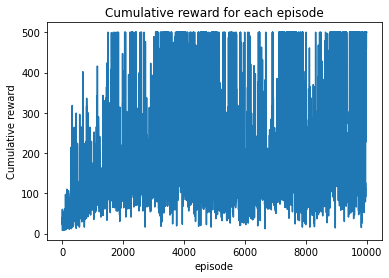

In [ ]:
agent = QAgent(env, bins, q_table, training_args)
cumulative_reward = agent.train()
episode_results = cumulative_reward
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

# 1.5 print values of state and chosen action of RL agent

In [ ]:
observation = env.reset()
action = agent.choose_action_test(observation)
print("Observation:",observation)
print("Chosen action:",action)


Observation: [ 0.0138751  -0.0382677  -0.04075671 -0.04907598]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

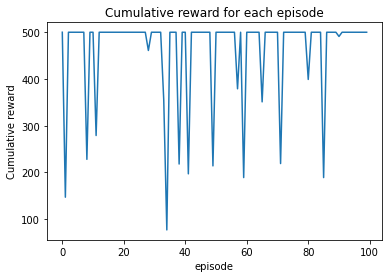

In [ ]:
episode_results = agent.test()
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", np.mean(episode_results))
print("Is my agent good enough?", np.mean(episode_results) > 195)

Average cumulative reward: 463.93
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = agent.choose_action(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

# 3.1 Tuning the parameters (reward, discount, etc.) to further improve output

# parameter testing code

In [ ]:
import pandas as pd
def Average(lst):
    return sum(lst) / len(lst)

def Average(lst):
    return sum(lst) / len(lst)

def parameter_test(episodes,learning_rate_lower,learning_rate_upper,learning_rate_step, bins_lower,bins_upper,bins_step, epsilon_decay_lower,epsilon_decay_upper,epsilon_decay_step,discount_lower,discount_upper,discount_step
                   ,outOfBoundsReward_lower,outOfBoundsReward_upper,outOfBoundsReward_step):
    df = pd.DataFrame()
    df['episodes'] = ''
    df['learning_rate'] = ''
    df['num_bins'] = ''
    df['epsilon_decay'] = ''
    df['discount'] = ''
    df['outOfBoundsReward'] = ''
    df['mean_score'] = ''
    for learning_rate in np.arange(learning_rate_lower,learning_rate_upper,learning_rate_step):
        print(learning_rate)
        for num_of_bins in range(bins_lower,bins_upper,bins_step):
            for epsilon_decay_value in np.arange(epsilon_decay_lower,epsilon_decay_upper,epsilon_decay_step):
                for discount in np.arange(discount_lower,discount_upper,discount_step):
                    for outOfBoundsReward in range(outOfBoundsReward_lower,outOfBoundsReward_upper,outOfBoundsReward_step):
                        env.reset()
                        bins = create_bins(num_of_bins)
                        q_table = create_q_table(obsSpaceSize, actionSpaceSize, num_of_bins)
                        training_args = TrainingArgs(learning_rate, discount, episodes, SHOW_EVERY, UPDATE_EVERY, EPSILON, epsilon_decay_value, MAXIMUM_STEPS_PER_EPISODE,outOfBoundsReward)
                        agent = QAgent(env, bins, q_table, training_args)
                        cumulative_reward = agent.train()
                        test_results = agent.test()
                        new_row = {'learning_rate': learning_rate, 'num_bins': num_of_bins,'epsilon_decay': epsilon_decay_value,'discount': discount ,'episodes': episodes, 'outOfBoundsReward': outOfBoundsReward,'mean_score':Average(test_results)}
                        df.loc[len(df)] = new_row

    return df





In [ ]:
#because too many changes in parameters will make code run for too long, we only
#varied certain factors
df = parameter_test(300,0.3,0.4,0.1,30,31,1,0.990,1,0.001,0.8,1,0.005,0,-10,-10)
#df = parameter_test(100,0.2,0.5,0.1,24,35,1,0.998,1,0.001,0.9,1,0.05,0,-10,-10)

Streaming output truncated to the last 5000 lines.
Episode:  100 Reward:  50.0
Episode:  101 Reward:  9.0
Episode:  102 Reward:  15.0
Episode:  103 Reward:  19.0
Episode:  104 Reward:  56.0
Episode:  105 Reward:  15.0
Episode:  106 Reward:  23.0
Episode:  107 Reward:  14.0
Episode:  108 Reward:  24.0
Episode:  109 Reward:  18.0
Episode:  110 Reward:  29.0
Episode:  111 Reward:  15.0
Episode:  112 Reward:  14.0
Episode:  113 Reward:  24.0
Episode:  114 Reward:  30.0
Episode:  115 Reward:  24.0
Episode:  116 Reward:  18.0
Episode:  117 Reward:  38.0
Episode:  118 Reward:  26.0
Episode:  119 Reward:  15.0
Episode:  120 Reward:  25.0
Episode:  121 Reward:  14.0
Episode:  122 Reward:  15.0
Episode:  123 Reward:  76.0
Episode:  124 Reward:  15.0
Episode:  125 Reward:  40.0
Episode:  126 Reward:  10.0
Episode:  127 Reward:  14.0
Episode:  128 Reward:  13.0
Episode:  129 Reward:  51.0
Episode:  130 Reward:  32.0
Episode:  131 Reward:  42.0
Episode:  132 Reward:  17.0
Episode:  133 Reward:  17.

In [ ]:
df.nlargest(5,'mean_score')

,episodes,learning_rate,num_bins,epsilon_decay,discount,outOfBoundsReward,mean_score
27,300,0.3,30,0.996,0.95,0,174.22
79,300,0.4,30,0.998,0.95,0,172.09
71,300,0.4,30,0.996,0.95,0,161.36
10,300,0.3,30,0.992,0.90,0,156.17
15,300,0.3,30,0.993,0.95,0,151.14


In [ ]:
#we will take the parameters with largest mean_score to train the agent again
largest_val = df.nlargest(1,'mean_score')
largest_val

,episodes,learning_rate,num_bins,epsilon_decay,discount,outOfBoundsReward,mean_score
27,300,0.3,30,0.996,0.95,0,174.22


In [ ]:
env.reset()
#train agent with optimised parameters
bins = create_bins(int(largest_val['num_bins'].iloc[0]))
q_table = create_q_table(obsSpaceSize, actionSpaceSize, int(largest_val['num_bins'].iloc[0]))
training_args = TrainingArgs(largest_val['learning_rate'].iloc[0], largest_val['discount'].iloc[0], EPISODES, SHOW_EVERY, UPDATE_EVERY, EPSILON, largest_val['epsilon_decay'].iloc[0], MAXIMUM_STEPS_PER_EPISODE,largest_val['outOfBoundsReward'].iloc[0])
agent = QAgent(env, bins, q_table, training_args)
new_umulative_reward = agent.train()
new_test_results = agent.test()

Streaming output truncated to the last 5000 lines.
Episode:  5000 Reward:  116.0
Episode:  5001 Reward:  108.0
Episode:  5002 Reward:  120.0
Episode:  5003 Reward:  110.0
Episode:  5004 Reward:  108.0
Episode:  5005 Reward:  107.0
Episode:  5006 Reward:  84.0
Episode:  5007 Reward:  123.0
Episode:  5008 Reward:  105.0
Episode:  5009 Reward:  110.0
Episode:  5010 Reward:  121.0
Episode:  5011 Reward:  114.0
Episode:  5012 Reward:  113.0
Episode:  5013 Reward:  143.0
Episode:  5014 Reward:  111.0
Episode:  5015 Reward:  94.0
Episode:  5016 Reward:  98.0
Episode:  5017 Reward:  107.0
Episode:  5018 Reward:  152.0
Episode:  5019 Reward:  111.0
Episode:  5020 Reward:  124.0
Episode:  5021 Reward:  96.0
Episode:  5022 Reward:  121.0
Episode:  5023 Reward:  95.0
Episode:  5024 Reward:  134.0
Episode:  5025 Reward:  95.0
Episode:  5026 Reward:  113.0
Episode:  5027 Reward:  119.0
Episode:  5028 Reward:  87.0
Episode:  5029 Reward:  117.0
Episode:  5030 Reward:  112.0
Episode:  5031 Reward:  11

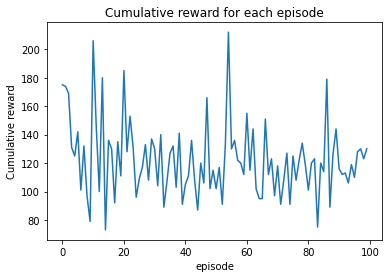

In [ ]:
plt.plot(new_test_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [ ]:
print("New Test Results Mean:", np.mean(new_test_results))
print("Old Test Results Mean:",np.mean(episode_results))


New Test Results Mean: 122.36
Old Test Results Mean: 463.93


Optimisation was not successful, there were too many parameters to vary so we had to reduce number of parameters varied. If not, the testing of parameters will take up to days to complete.
Number of episodes were too little  to see a more accurate depiction of the effectiveness of each change in the parameter since we kept learning rate low.